In [20]:
import pandas as pd
from datasets import load_dataset
import random
import sqlite3
from local_email_db import DEFAULT_DB_PATH

# Load the dataset from Hugging Face
dataset = load_dataset("corbt/enron_emails_sample_questions")

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset["train"])  # type: ignore

# Print basic dataset info
print(f"Dataset size: {len(df)} samples")
print(f"Columns: {df.columns.tolist()}")
print(f"Number of unique inboxes: {df['inbox_address'].nunique()}")
print(f"Average realism score: {df['how_realistic'].mean():.2f}")

# Connect to the SQLite database
conn = sqlite3.connect(DEFAULT_DB_PATH)
cursor = conn.cursor()

samples = df[df["how_realistic"] > 0.89].sample(n=5)

# Display the samples
for i, sample in enumerate(samples.itertuples(), 1):
    print(f"\n--- Sample {i} ---")
    print(f"Question: {sample.question}")
    print(f"Answer: {sample.answer}")
    print(f"Inbox: {sample.inbox_address}")
    print(f"Message IDs: {sample.message_ids}")
    print(f"Realism score: {sample.how_realistic:.2f}")
    print(f"Query date: {sample.query_date}")

    # Look up and display the referenced emails
    print("\nReferenced Emails:")
    for msg_id in sample.message_ids:
        # Query the database for the email with this message_id
        cursor.execute(
            """
            SELECT e.id, e.subject, e.from_address, e.date, e.body
            FROM emails e
            WHERE e.message_id = ?
            """,
            (msg_id,),
        )
        email = cursor.fetchone()

        if email:
            email_id, subject, from_address, date, body = email

            # Get recipients
            cursor.execute(
                """
                SELECT recipient_address, recipient_type
                FROM recipients
                WHERE email_id = ?
                """,
                (email_id,),
            )
            recipients = cursor.fetchall()

            # Format recipients by type
            to_list = [addr for addr, type in recipients if type == "to"]
            cc_list = [addr for addr, type in recipients if type == "cc"]
            bcc_list = [addr for addr, type in recipients if type == "bcc"]

            # Print email details
            print(f"\nMessage ID: {msg_id}")
            print(f"Subject: {subject}")
            print(f"From: {from_address}")
            print(f"Date: {date}")
            print(f"To: {', '.join(to_list)}")
            if cc_list:
                print(f"CC: {', '.join(cc_list)}")
            if bcc_list:
                print(f"BCC: {', '.join(bcc_list)}")
            print(f"Body:\n{body[:500]}..." if len(body) > 500 else f"Body:\n{body}")
        else:
            print(f"\nMessage ID: {msg_id} - Not found in database")

# Close the database connection
conn.close()


Generating train split: 100%|██████████| 2272/2272 [00:00<00:00, 504017.49 examples/s]

Dataset size: 2272 samples
Columns: ['question', 'answer', 'message_ids', 'how_realistic', 'inbox_address']
Number of unique inboxes: 28
Average realism score: 0.81

--- Sample 1 ---
Question: Who did Mark ask me to contact regarding Brazilian power trading contracts?
Answer: Mark asked you and Sara to contact Andrea Bertone in Sao Paolo to discuss documentation for Enron's first electricity trading transaction in Brazil.
Inbox: elizabeth.sager@enron.com
Message IDs: ['<31750049.1075859882901.JavaMail.evans@thyme>']
Realism score: 0.90

Referenced Emails:

Message ID: <31750049.1075859882901.JavaMail.evans@thyme>
Subject: Brazilian Power Trading Contratcts
From: mark.taylor@enron.com
Date: 1999-03-25 11:54:00
To: sara.shackleton@enron.com, elizabeth.sager@enron.com
Body:
Could you guys please get in touch with Andrea Bertone in Sao Paolo & send 
her copies of our forms that might be useful in coming up with appropriate 
documentation for this transaction.  Sara - you should probably di

<Axes: >

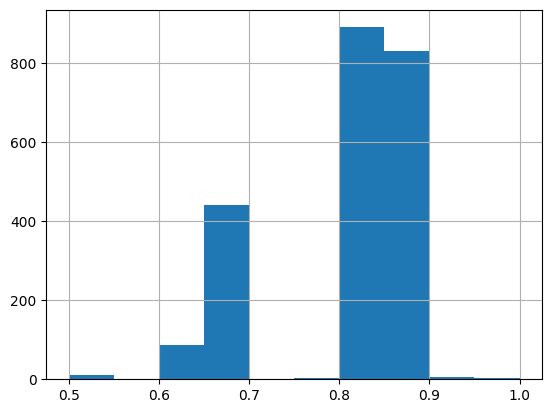

In [21]:
df.how_realistic.hist()